In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots a per-event array (in this case, Jet pT). In Coffea, this is not very dissimilar from the event-level process.

class JetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        Jet_pt = df['Jet_pt']
        # As before, we can get the number of events by checking the size of the array. To get the number of jets, which varies per event, though, we need to count up the number in each event, and then sum those counts (count subarray sizes, sum them).
        output['cutflow']['all events'] += Jet_pt.size
        output['cutflow']['all jets'] += Jet_pt.counts.sum()
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=Jet_pt.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'Jets': ["root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv4/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/50000/C9B654CF-0B51-4444-A177-479200DCC429.root"]}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=JetProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 500000)

Processing: 100%|██████████| 3/3 [00:13<00:00,  4.51s/items]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (Jets) instance at 0x7fb4e4035780>: [<matplotlib.collections.PolyCollection at 0x7fb535fe6390>],
  'legend': <matplotlib.legend.Legend at 0x7fb535fe6668>})

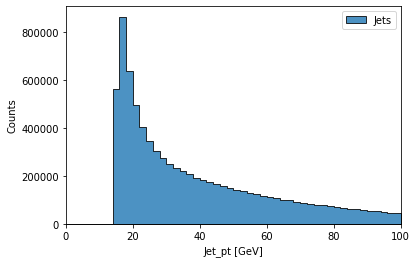

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 1118000
all jets 9084232
